## Motivation

In this notebook, we exame the idea declared in section 1.5.5 on Fashion MNIST data, a classification task.

The model follows: https://www.kaggle.com/code/m0hand/fashion-mnist-cnn

In [1]:
# !wget https://raw.githubusercontent.com/shuiruge/maxent/master/actions/utils.py

--2024-03-24 07:27:45--  https://raw.githubusercontent.com/shuiruge/maxent/master/actions/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4137 (4.0K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   4.04K  --.-KB/s    in 0s      

2024-03-24 07:27:45 (55.4 MB/s) - ‘utils.py’ saved [4137/4137]



In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.losses import MSE, CategoricalCrossentropy
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from utils import GradientRelativeEntropy

tf.random.set_seed(42)

## The MNIST Data

In [3]:
mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = tf.convert_to_tensor(x_train / 255.0, 'float32')
x_test = tf.convert_to_tensor(x_test / 255.0, 'float32')
y_train = tf.one_hot(y_train, 10, dtype='float32')
y_test = tf.one_hot(y_test, 10, dtype='float32')

x_train.shape, y_train.shape

4422102/4422102 [==============================] - 0s 0us/step


(TensorShape([60000, 28, 28]), TensorShape([60000, 10]))

## Train a Model with Gradient Loss

In [4]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, 'relu'),
    Dense(10, 'softmax')
])

gradient_loss_fn = GradientRelativeEntropy(model)

In [5]:
optimizer = tf.optimizers.Adam()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        gradient_loss = gradient_loss_fn(x, y)
    grads = tape.gradient(gradient_loss.loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return gradient_loss.loss

In [6]:
def evaluate(model):
    return accuracy_score(
        tf.argmax(y_test, axis=1),
        tf.argmax(model(x_test), axis=1),
    )

In [7]:
ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds = ds.batch(100)

In [8]:
for epoch in range(20):
    for x, y in tqdm(ds):
        loss = train_step(x, y)
    print(epoch, loss.numpy(), evaluate(model))

100%|██████████| 600/600 [00:14<00:00, 42.82it/s] 


0 0.018842889 0.8054


100%|██████████| 600/600 [00:04<00:00, 127.93it/s]


1 0.017179072 0.846


100%|██████████| 600/600 [00:03<00:00, 161.71it/s]


2 0.016804801 0.8594


100%|██████████| 600/600 [00:03<00:00, 189.52it/s]


3 0.016679283 0.8701


100%|██████████| 600/600 [00:03<00:00, 183.10it/s]


4 0.016442847 0.8751


100%|██████████| 600/600 [00:03<00:00, 190.57it/s]


5 0.016490102 0.8792


100%|██████████| 600/600 [00:03<00:00, 189.94it/s]


6 0.016200982 0.8877


100%|██████████| 600/600 [00:03<00:00, 188.04it/s]


7 0.016018802 0.8894


100%|██████████| 600/600 [00:03<00:00, 185.81it/s]


8 0.016018117 0.8854


100%|██████████| 600/600 [00:03<00:00, 189.20it/s]


9 0.016136598 0.8865


100%|██████████| 600/600 [00:03<00:00, 189.11it/s]


10 0.01595376 0.8937


100%|██████████| 600/600 [00:05<00:00, 117.61it/s]


11 0.016135354 0.8877


100%|██████████| 600/600 [00:03<00:00, 186.90it/s]


12 0.015967306 0.8888


100%|██████████| 600/600 [00:03<00:00, 189.23it/s]


13 0.015888285 0.8921


100%|██████████| 600/600 [00:03<00:00, 182.30it/s]


14 0.01631404 0.8852


100%|██████████| 600/600 [00:03<00:00, 188.78it/s]


15 0.015946122 0.8918


100%|██████████| 600/600 [00:03<00:00, 188.43it/s]


16 0.015885908 0.8877


100%|██████████| 600/600 [00:03<00:00, 188.02it/s]


17 0.015666153 0.8947


100%|██████████| 600/600 [00:03<00:00, 183.86it/s]


18 0.015493089 0.8949


100%|██████████| 600/600 [00:03<00:00, 172.24it/s]


19 0.016118828 0.8965


In [9]:
evaluate(model)

0.8965

## Baseline Model with Usual Loss

In [10]:
baseline_model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, 'relu'),
    Dense(10, 'softmax')
])

In [11]:
baseline_model.compile(
    optimizer='adam',
    loss=CategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [12]:
baseline_model.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_test, y_test),
    verbose=2,
)

Epoch 1/20
1875/1875 - 9s - loss: 0.4667 - accuracy: 0.8311 - val_loss: 0.3546 - val_accuracy: 0.8721 - 9s/epoch - 5ms/step
Epoch 2/20
1875/1875 - 6s - loss: 0.3109 - accuracy: 0.8872 - val_loss: 0.3577 - val_accuracy: 0.8695 - 6s/epoch - 3ms/step
Epoch 3/20
1875/1875 - 7s - loss: 0.2687 - accuracy: 0.9010 - val_loss: 0.2977 - val_accuracy: 0.8941 - 7s/epoch - 4ms/step
Epoch 4/20
1875/1875 - 6s - loss: 0.2359 - accuracy: 0.9134 - val_loss: 0.2682 - val_accuracy: 0.9026 - 6s/epoch - 3ms/step
Epoch 5/20
1875/1875 - 6s - loss: 0.2122 - accuracy: 0.9217 - val_loss: 0.2793 - val_accuracy: 0.8991 - 6s/epoch - 3ms/step
Epoch 6/20
1875/1875 - 6s - loss: 0.1903 - accuracy: 0.9295 - val_loss: 0.2899 - val_accuracy: 0.8950 - 6s/epoch - 3ms/step
Epoch 7/20
1875/1875 - 6s - loss: 0.1716 - accuracy: 0.9356 - val_loss: 0.2631 - val_accuracy: 0.9106 - 6s/epoch - 3ms/step
Epoch 8/20
1875/1875 - 6s - loss: 0.1555 - accuracy: 0.9416 - val_loss: 0.2672 - val_accuracy: 0.9092 - 6s/epoch - 3ms/step
Epoch 9/

In [13]:
evaluate(baseline_model)

0.9044

## Model Robustness

Now, we compare the robustness of the model and the baseline. To do so, we add Gaussian noise to the test data and check the accuracy.

In [21]:
stddevs, model_accs, baseline_accs = [], [], []
for stddev in tqdm(np.linspace(0, 0.2, 20)):
    stddevs.append(stddev)
    x_test_noised = x_test + tf.random.normal(tf.shape(x_test)) * stddev
    x_test_noised = tf.clip_by_value(x_test_noised, 0., 1.)
    model_accs.append(
        accuracy_score(tf.argmax(y_test, axis=1),
                       tf.argmax(model(x_test_noised), axis=1))
    )
    baseline_accs.append(
        accuracy_score(tf.argmax(y_test, axis=1),
                       tf.argmax(baseline_model(x_test_noised), axis=1))
    )

100%|██████████| 20/20 [00:04<00:00,  4.44it/s]


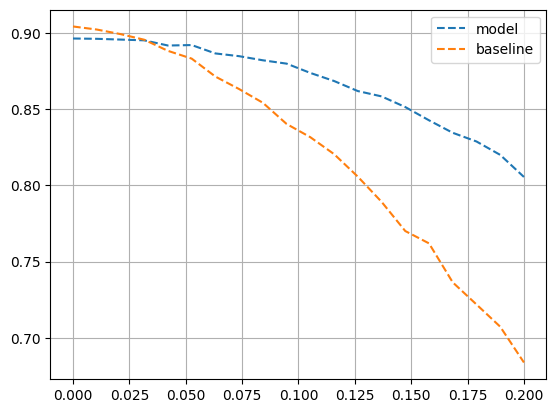

In [22]:
plt.plot(stddevs, model_accs, '--', label='model')
plt.plot(stddevs, baseline_accs, '--', label='baseline')
plt.legend()
plt.grid()
plt.show()

And for uniform perturbation:

In [23]:
stddevs, model_accs, baseline_accs = [], [], []
for stddev in tqdm(np.linspace(0, 0.2, 20)):
    stddevs.append(stddev)
    x_test_noised = x_test + tf.random.uniform(tf.shape(x_test), -1., 1.) * stddev
    x_test_noised = tf.clip_by_value(x_test_noised, 0., 1.)
    model_accs.append(
        accuracy_score(tf.argmax(y_test, axis=1),
                       tf.argmax(model(x_test_noised), axis=1))
    )
    baseline_accs.append(
        accuracy_score(tf.argmax(y_test, axis=1),
                       tf.argmax(baseline_model(x_test_noised), axis=1))
    )

100%|██████████| 20/20 [00:04<00:00,  4.40it/s]


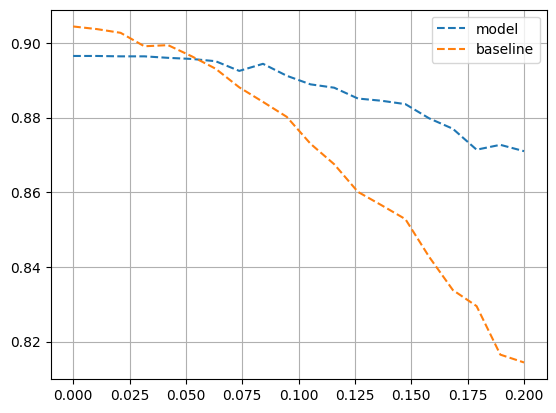

In [24]:
plt.plot(stddevs, model_accs, '--', label='model')
plt.plot(stddevs, baseline_accs, '--', label='baseline')
plt.legend()
plt.grid()
plt.show()

Or, non-Gaussian "pixal-flipping" noise.

In [25]:
flip_ratios, model_accs, baseline_accs = [], [], []
for flip_ratio in tqdm(np.linspace(0, 0.1, 20)):
    flip_ratios.append(flip_ratio)
    x_test_noised = tf.where(tf.random.uniform(tf.shape(x_test)) < flip_ratio, 1 - x_test, x_test)
    model_accs.append(
        accuracy_score(tf.argmax(y_test, axis=1),
                       tf.argmax(model(x_test_noised), axis=1))
    )
    baseline_accs.append(
        accuracy_score(tf.argmax(y_test, axis=1),
                       tf.argmax(baseline_model(x_test_noised), axis=1))
    )

100%|██████████| 20/20 [00:04<00:00,  4.38it/s]


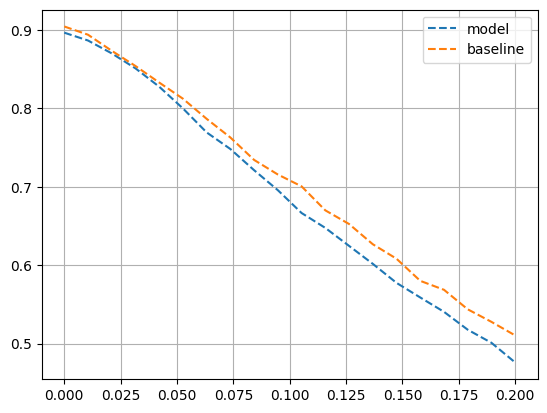

In [26]:
plt.plot(stddevs, model_accs, '--', label='model')
plt.plot(stddevs, baseline_accs, '--', label='baseline')
plt.legend()
plt.grid()
plt.show()

## Conclusion

- By simply using the "gradient loss", we obtained a result that approaches the baseline. But the robustness is greatly out-performs the baseline.
- Because the "gradient loss" computes gradients twice (once by x and y, and once by model variables), the training duration is doubled.
- We also tested non-Gaussian noise, such as flipping the given ratio of pixals. The result is that the model trained by the "gradient loss" is no more robust, but no less, than the baseline model. The difference is that the pixal-flipping noise is not continuous. The noised images jump to other local minima of the loss function.